# Introduction

This work reproduces the original paper from Duvenaud, *et. al.* on the development of convolutional neural networks applied on molecular graphs that generate molecular fingerprints (i.e., embeddings) for downstream property prediction. Citation to the original paper [1]:

Duvenaud, D. K., Maclaurin, D., Iparraguirre, J., Bombarell, R., Hirzel, T., Aspuru-Guzik, A., and Adams, R. P. (2015) Convolutional networks on graphs for learning molecular fingerprints. *Advances in Neural Information Processing Systems*, 2224-2232.

The Github repository to this replication work can be found at [https://github.com/wangcp93/dlh-fps](https://github.com/wangcp93/dlh-fps)

The video recording of the presentation can be found at [https://mediaspace.illinois.edu/media/t/1_621jkz39](https://mediaspace.illinois.edu/media/t/1_621jkz39)

## General Problem

This paper aims at learning molecular features using molecule graphs of arbitrary size and shape as inputs. This is an important problem in drug discovery because molecular feature extraction is the foundation for downstream tasks, such as molecular property prediction. The main challenge of this problem is to realize end-to-end learning, i.e., using molecule graphs as the direct inputs rather than converting them to fixed-size inputs via predefined rules.

Before this paper, the state of the art was to use extended-connectivity circular fingerprints (ECFP) of molecules [2], which are fixed-dimensional multi-hot vectors relying on hand-crafted features. These vectors are often very high-dimensional but sparse. Also, they are fixed regardless of downstream tasks, so the predictive power is limited in many tasks.

## Approach to the Problem

This paper generalizes the circular fingerprints to “neural fingerprints”, which are optimizable based on downstream tasks and data. To facilitate the training, this method replaces several non-differentiable operations to a differentiable neural network. By doing so, the model can be trained in an end-to-end manner directly from molecule graphs. Specifically, in each layer:

* A smooth activation function replaces the hashing operation to combine information from the neighborhood of each atom.
* A softmax function replaces the indexing (argmax) operation to sparsify each atom’s feature vector.
* A real-valued fingerprint vector replaces the binary vector to better preserve similarity information between substructures.

This paper demonstrated that, compared with circular fingerprints, the neural fingerprints are more interpretable, and the predictive errors on 3 downstream tasks (solubility, drug efficacy, photovoltaic efficiency) can be much lower.
Such approach applies the same operation locally everywhere and combines information in a global pooling step, which resembles a convolutional network. In fact, though not explicitly, this paper was the first that proposed the idea of graph convolutional network (GCN).

# Scope of Reproducibility

## Hypothesis Testing

The folliwing hypotheses from the paper will be tested in this work:

1. Hypothesis 1: Data-driven neural fingerprints achieve greater predictive performances than fixed circular fingerprints.

2. Hypothesis 2: Circular fingerprints are a special case of neural fingerprints by having large random weights.

To test the first hypothesis, this work will replicate the studies on 3 downstream tasks provided in the paper (solubility, drug efficacy, and photovoltaic efficacy) to evaluate the model performance. The Methodology section defines the model architecture and training process to support this study.

To test the second hypothesis, this work will replicate the training of the model using large and small random weights, respectively, to show that the former achieves similar performance as circular fingerprints, while the latter gives better results.


## Ablation Study

Key differences between the neural fingerprints and circular fingerprints are the use of (a) a neural network instead of a hashing operation, and (b) a softmax function to give a real-valued vector instead of an indexing operation to give a binary vector. While (a) is the main contribution, its ablation is challenging due to the non-differentiable nature of the hashing operation. Here, I propose ablation study on (b). Specifically:

* After the neural network layer, use a softmax with small temperature to mimic the indexing operation that generates nearly binary vectors as fingerprints.

Softmax with temperature ($T$) is defined as:

$\text{softmax}_T(\textbf{z})_i = \frac{\exp{(z_i / T)}}{\sum_j{\exp{(z_j / T)}}}$


Regular softmax takes $T=1$. A temperature lower than 1 enlarges the differences between dimensions. When $T \rightarrow 0$, it essentially becomes a "hard max", i.e., the dimension with maximum value becomes 1 while all others are 0. In this ablation study, I take $T = 0.01$, which typically gives >0.99 for the dimension with max value and ~0 for the rest. This approximates the indexing operation and thus yielding nearly binary fingerprint vectors.

This ablation study is to assess whether real-valued fingerprint vectors are advantageous over binary vectors, depending on whether predictive performances are significantly different using two softmax temperatures.

# Methodology

This study uses Python version 3.11.4.

In [1]:
!python --version

Python 3.11.4


The necessary packages are imported below. Some helper functions are written by the original authors and directly imported, mainly related to molecular data processing. Other plotting functions are self-implemented to support visualization in the results section.

In [2]:
'''Import packages'''
import numpy as np
import pandas as pd
import random
import os
import sys
import time
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

'''Import helper codes from the authors for molecular data processing'''
sys.path.append("neuralfingerprint")

# Converts smiles to mol graphs and extract atom and bond features
from mol_graph import graph_from_smiles_tuple

# Import the atom and bond feature length for building the model
from features import num_features

'''Import helper codes for plotting and visualization'''
sys.path.append("visplotting")
from plot_funcs import print_label_statistics, plot_train_loss, \
                       plot_train_val_error, plot_rmse_over_layers

The seeds are set below to ensure reproducibility.

In [3]:
# set seed
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

## Data

This paper uses 3 datasets for training and performance evaluation:

* Solubility: The aqueous solubility of ~1100 organic molecules, measured in mols per litre in log scale [3].
* Drug efficacy: The half-maximal effective concentration (EC<sub>50</sub>) in vitro in log scale of ~10,000 molecules against a sulfide-resistant strain of *P. falciparum*, the parasite that causes malaria [4].
* Organic photovoltaic efficiency: The DFT-simulated photovoltaic efficiency of ~30,000 organic molecules from the Harvard Clean Energy Project [5].

Each molecule is represented by a SMILES string. All the data have been preprocessed by the authors which removed entries with invalid SMILES strings. These data are provided by the authors as csv files. Because of the small sizes, they are directly accessed from local folders.

The SMILES strings are the only input to the model (besides true labels), which will be translated to feature vectors (see below) during training and validation. Because all molecules in the same batch are processed simultaneously and efficiently, SMILES strings are used as the direct inputs without further preprocessing at this stage.


### Molecular Features

The paper processes the molecules using rdkit and self-defined methods in `mol_graph.py` to generate molecular graphs and extract features. The features include atom features and bond features defined in `features.py`. Specifically:

* Initial atom features concatenate a one-hot encoding of the atom’s element, its degree, the number of attached hydrogen atoms, the implicit valence, and an aromaticity indicator.
* The bond features are a concatenation of whether the bond type was single, double, triple, or aromatic, whether the bond was conjugated, and whether the bond was part of a ring.

The feature vector lengths are shown below.

In [4]:
atom_feature_size, bond_feature_size = num_features()
print("Atom feature vector length:", atom_feature_size)
print("Bond feature vector length:", bond_feature_size)

Atom feature vector length: 62
Bond feature vector length: 6


### Load datasets

Below the 3 datasets are loaded separately. Some helper functions and values are defined below.

In [5]:
# Data directory
data_dir = 'data'

# Define validation and test ratio
val_ratio = 0.1
test_ratio = 0.1

# Load data as a Pandas data frame. The true label column is renamed as "label"
def load_data(data_dir, data_file, target_name):
    df = pd.read_csv(f"{data_dir}/{data_file}")[["smiles", target_name]]
    df.rename(columns={target_name: "label"}, inplace = True)
    return df

### 1. Solubility Dataset

The Solubility dataset is imported below:

In [6]:
sol_df = load_data(data_dir, data_file = 'delaney.csv',
                   target_name = 'measured log solubility in mols per litre')
sol_df.head()

,smiles,label
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77
1,Cc1occc1C(=O)Nc2ccccc2,-3.30
2,CC(C)=CCCC(C)=CC(=O),-2.06
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87
4,c1ccsc1,-1.33


The dataset is split into training, validation and test sets. The test set is saved for the final evaluation, while the training and validation sets are used for training (split before training). Below the test set is split and saved:

In [7]:
# Splitting into train+val and test sets. Save the test set for final evaluation
sol_train_val_df, sol_test_df = train_test_split(sol_df, test_size = test_ratio, random_state = seed)

print("Dataset size:", sol_df.shape[0])
print("Test set size:", sol_test_df.shape[0] )

Dataset size: 1128
Test set size: 113


Statistics of the label, i.e., log solubility of molecules, are shown below.

Count: 1128
Mean: -3.05
Stdev: 2.10
Median: -2.86
Max: 1.58
Min: -11.60


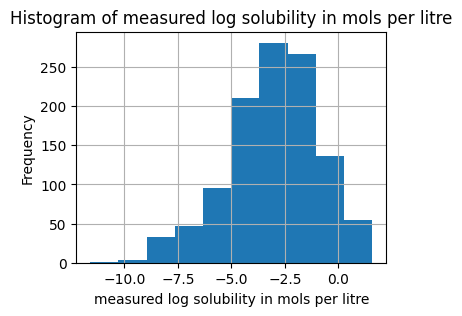

In [8]:
print_label_statistics(sol_df, 'measured log solubility in mols per litre')

**Figure 1**: Histogram of measured log solubility in mols per litre for Solubility dataset.

### 2. Drug Efficacy Dataset

The Drug Efficacy dataset is imported below, followed by train/test split and statistics review.

In [9]:
eff_df = load_data(data_dir, data_file = 'malaria.csv', target_name = 'activity')
eff_df.head()

,smiles,label
0,Cc1nc2cc(ccc2[nH]1)c3ccc4[nH]c(C)nc4c3,0.738598
1,CN(C1CCN(C)C1)c2cc(C)nc(Nc3ccc(Cl)cc3)n2,-1.090085
2,CN(C)CCCOc1cc(NC(=O)Nc2ccc(c3ccncc3)c4ccccc24)...,-0.358682
3,COc1ccc(cc1CSc2nc3ccccc3[nH]2)C4NCCc5c4[nH]c6c...,0.561329
4,CCN1C(=Nc2sc3CN(C)CCc3c2C1=O)SCc4ccc(F)cc4,-1.371137


In [10]:
# Splitting into train+val and test sets. Save the test set for final evaluation
eff_train_val_df, eff_test_df = train_test_split(eff_df, test_size = test_ratio, random_state = seed)

print("Dataset size:", eff_df.shape[0])
print("Test set size:", eff_test_df.shape[0] )

Dataset size: 9999
Test set size: 1000


Count: 9999
Mean: -0.34
Stdev: 1.22
Median: -0.22
Max: 2.71
Min: -6.92


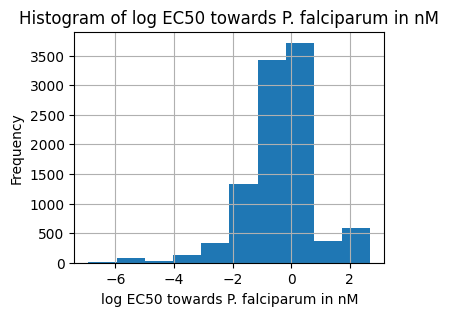

In [11]:
print_label_statistics(eff_df, 'log EC50 towards P. falciparum in nM')

**Figure 2**: Histogram of log EC<sub>50</sub> in nM towards *P. falciparum* for Drug efficacy dataset.

### 3. Photovoltaic Efficiency Dataset

The Organic Photovoltaic Efficiency dataset is imported below, followed by train/test split and statistics review.

In [12]:
pce_df = load_data(data_dir, data_file = 'cep.csv', target_name = 'PCE')
pce_df.head()

,smiles,label
0,c1cc2c3cocc3c3c4[SiH2]C(=Cc4ncc3c2[se]1)c1scc2...,3.596639
1,C1C=Cc2ncc3c4[se]c(cc4c4=C[SiH2]C=c4c3c12)-c1c...,5.993001
2,[nH]1c(cc2c3nsnc3c3c4ccccc4oc3c12)-c1ccco1,2.855376
3,[nH]1c2cc(-c3nccc4nsnc34)c3nsnc3c2c2ncc3cccnc3c12,7.611321
4,[nH]1c2ccc3c[nH]cc3c2c2ccc3cc(ncc3c12)-c1scc2s...,1.471250


In [13]:
# Splitting into train+val and test sets. Save the test set for final evaluation
pce_train_val_df, pce_test_df = train_test_split(pce_df, test_size = test_ratio, random_state = seed)

print("Dataset size:", pce_df.shape[0])
print("Test set size:", pce_test_df.shape[0] )

Dataset size: 29978
Test set size: 2998


Count: 29978
Mean: 3.90
Stdev: 2.54
Median: 3.41
Max: 11.09
Min: -6.95


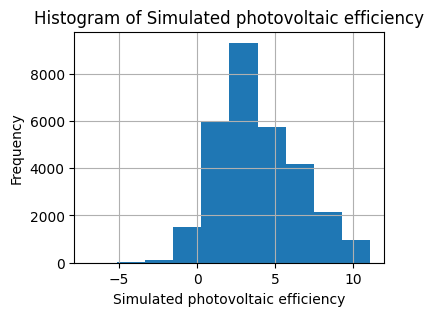

In [14]:
print_label_statistics(pce_df, 'Simulated photovoltaic efficiency')

**Figure 3**: Histogram of Simulated photovotaic efficiency for Photovotaic efficiency dataset.

##   Model

The model architecture follows the original paper by Duvenaud, *et. al.* [1]. The original paper's Github repo can be found at [https://github.com/HIPS/neural-fingerprint](https://github.com/HIPS/neural-fingerprint).

The neural graph fingerprints algorithm is outlined below:

**Input**: molecule, radius $R$, neighbor feature weights $W_1^n$, ..., $W_R^n$, fingerprint weights $W_1^f$, ..., $W_{R}^f$

**Initialize**: fingerprint vector $\textbf{f}=\textbf{0}$

**for** each atom $a$ in molecule

&emsp; $\textbf{r}_a = g(a)$ &emsp; *# lookup atom features*

**for** $L = 1$ to $R$ &emsp; *# for each layer*

&emsp; **for** each atom $a$ in molecule

&emsp;&emsp; $\textbf{r}_1 ... \textbf{r}_N = \text{neighbors}(a)$

&emsp;&emsp; $\textbf{v} = \textbf{r}_a + \sum_{i=1}^N{\textbf{r}_i}$

&emsp;&emsp; $\textbf{r}_a = \text{ReLU}(W_L^n\textbf{v})$ &emsp; *# update atom features*

&emsp;&emsp; $\textbf{i} = \text{Softmax} (W_L^f\textbf{r}_a)$

&emsp;&emsp; $\textbf{f} = \textbf{f} + \textbf{i}$ &emsp; *# add to fingerprint*

**Return**: real-valued vector $\textbf{f}$

In this algorithm:

* The radius $R$, also called fingerprint depth, is essentially the number of layers in the neural network, where each layer extends neighbor coverage by one atom. This is why it is called the radius. In the main reproduction work, I used $R = 4$.

* For each atom $a$, the neighbor vectors $\textbf{r}_1 ... \textbf{r}_N$ are a concatenation of the neighbor's atom feature (length 62) and bond feature (length 6). This paper chooses summation as a permutation-invariant pooling method. The sum vector $\textbf{v}$ forms the neighbor feature vector of atom $a$.

* The neighbor feature weight $W_L^n$ converts the neighbor feature vector to a hidden vector. The hidden dimension (also called fingerprint width) is chosen to be 50. After ReLU activation, the new vector becomes the updated atom feature for atom $a$, which includes the neighborhood information.

* The fingerprint weight $W_L^f$ followed by softmax activation converts the updated atom feature to a fingerprint vector $\textbf{i}$. The fingerprint length is chosen to be 50. Fingerprints of each atom from each layer are all added to form the fingerprint of the molecule $\textbf{f}$.

Finally, the output module on top of the fingerprints is a two-layer neural network, where the hidden layer size is chosen to be 100, and the activation function is ReLU. The final output is a numerical value for property prediction.

It is noteworthy that, despite the pseudocode of the algorithm uses distinct for loops over atoms in a molecule, all atoms in the molecule are calculated simultaneously. In fact, all molecules within the same batch are handled simultaneously by the code.

Lastly, there is no pretraining or simulation involved in the model. Each dataset is trained separately end-to-end.

### Model Class

Because the original paper used outdated codes to build the model and perform the training, I rewrite the model codes using PyTorch. The model class built on torch.nn class module is defined below. 

In [15]:
'''
fp_length is the dimension of the fingerprint vector
fp_depth is the number of layers of neural networks for fingerprint generation
fp_width is the dimension of updated atom feature vectors during each layer of fingerprint generation
pred_hidden_size is the dimension of the hidden layer between fingerprint and final prediction
atom_feature_size is the dimension of the original atom feature vector, here it is 62
bond_feature_size is the dimension of the bond feature vector, here it is 6
degrees indicate how many non-H atoms connect to a given atom. Atoms are sorted by degrees
with_temp indicates whether Softmax with temperature is used, True only for ablation studies
'''

class NeuralFingerprint(nn.Module):    
    def __init__(self, fp_length, fp_depth, fp_width, pred_hidden_size, atom_feature_size = atom_feature_size,
                 bond_feature_size = bond_feature_size, degrees = (0,1,2,3,4,5), with_temp = False):
        
        super(NeuralFingerprint, self).__init__()
               
        self.layers = fp_depth
        self.degrees = degrees 
        self.bond_size = bond_feature_size
        self.with_temp = with_temp

        # Linear layers that maps neighbor feature vectors to updated atom features. Separate for each layer
        # First layer maps from (atom_feature_size + bond_feature_size) to fp_width
        # Following layers (if any) map from (fp_width + bond_feature_size) to fp_width
        W_neighbors = [nn.Linear(atom_feature_size + bond_feature_size, fp_width)]  # First layer
        for _ in range(self.layers - 1):
            W_neighbors.append(nn.Linear(fp_width + bond_feature_size, fp_width))  # Following layers     
        self.W_neighbors = nn.ModuleList(W_neighbors)

        # Linear layers that map updated atom features to fingerprints. Separate for each layer
        W_fps = [nn.Linear(fp_width, fp_length) for _ in range(self.layers)]
        self.W_fps = nn.ModuleList(W_fps)        
        
        # Linear layer that maps fingerprint to a hidden layer
        self.W_hid = nn.Linear(fp_length, pred_hidden_size)
        
        # Final prediction layer
        self.W_pred = nn.Linear(pred_hidden_size, 1)
    
    
    '''Change the initial scale of parameters of fingerprint generation. For hypothesis testing only'''
    def initialize_weights(self, scale):
        for layer in range(self.layers):
            nn.init.uniform_(self.W_neighbors[layer].weight, -scale, scale)
            nn.init.uniform_(self.W_fps[layer].weight, -scale, scale)
    
    
    '''
    Authors' code. Generates array representations for smiles, including atom features and bond features
    Handles a batch of smiles simultaneously
    The atom list and neighbors list record which atoms/bonds belong to which molecule, ordered by degrees
    '''
    def array_rep_from_smiles(self, smiles_batch):
        molgraph = graph_from_smiles_tuple(smiles_batch)
        arrayrep = {
            'atom_features' : molgraph.feature_array('atom'),
            'bond_features' : molgraph.feature_array('bond'),
            'atom_list'     : molgraph.neighbor_list('molecule', 'atom')
        }
        for degree in self.degrees:
            arrayrep[('atom_neighbors', degree)] = \
                torch.tensor(molgraph.neighbor_list(('atom', degree), 'atom'), dtype = torch.int)
            arrayrep[('bond_neighbors', degree)] = \
                torch.tensor(molgraph.neighbor_list(('atom', degree), 'bond'), dtype = torch.int)
        return arrayrep

    
    '''
    Helper function that finds the neighbors of each atom and concatenates with bond features
    Then generates neighbor feature vectors by summing up neighbors
    '''
    def generate_neighbors(self, array_rep, atom_features, bond_features):
        
        # Sort neighbors by degrees
        neighbors_by_degree = []
        
        for degree in self.degrees:
            atom_neighbors_list = array_rep[('atom_neighbors', degree)]
            bond_neighbors_list = array_rep[('bond_neighbors', degree)]
           
            if len(atom_neighbors_list) > 0:
                neighbor_features = [atom_features[atom_neighbors_list],
                                     bond_features[bond_neighbors_list]]

                # dim of stacked_neighbors is (num_atoms, num_neighbors, neighbor_feature_dim)
                stacked_neighbors = torch.cat(neighbor_features, dim=2)

                # dim of summed_neighbors is (num_atoms, neighbor_feature_dim)
                summed_neighbors = torch.sum(stacked_neighbors, dim=1)
                neighbors_by_degree.append(summed_neighbors)

        # Concatenate neighbor features from all degrees. Output dim is (total_num_atoms, neighbor_feature_dim)
        return torch.cat(neighbors_by_degree, dim=0)
    
    
    '''Updates the atom features based on neighbor information in each layer'''
    def update_layer(self, array_rep, atom_features, bond_features, layer):
        
        # Pad 0's at the end of the atom feature vector to make it the same size as neighbors
        # Output dim is (num_atoms, neighbor_feature_dim)
        pad_dim = (0, self.bond_size)
        padded_atom_features = nn.functional.pad(atom_features, pad_dim)
        
        # Sum up padded atom features and neighbor features. Output dim is (num_atoms, neighbor_feature_dim)
        neighbor_features = self.generate_neighbors(array_rep, atom_features, bond_features)
        summed_features = padded_atom_features + neighbor_features
        
        # Apply linear layer and ReLU to give updated atom features. Output dim is (num_atoms, fp_width)
        summed_linear = self.W_neighbors[layer](summed_features)
        return torch.relu(summed_linear)
    
    
    '''Converts updated atom features to fingerprints in a single layer'''
    def feature_to_fp(self, array_rep, atom_features, layer):
        
        # Define softmax with temperature (T). For ablation study only
        # By setting T = 0.01, softmax is very close to hard max (>0.99 for the max value, ~0 for the rest).        
        def softmax_with_T(matrix, dim, T = 0.01):
            temp_adj_matrix = matrix / T
            return torch.softmax(temp_adj_matrix, dim=dim)
        
        
        # Apply the linear layer followed by softmax activation. Output dim is (num_atoms, fp_length)
        # If with_temp is True, softmax with temperature (T) is used.
        if self.with_temp:
            atom_outputs = softmax_with_T(self.W_fps[layer](atom_features), dim=1)
        
        # If not, regular softmax is used for model building.
        else:
            atom_outputs = torch.softmax(self.W_fps[layer](atom_features), dim=1)

        # Reorganize atoms for each molecule in the batch, and sum up fingerprints for each molecule
        mol_outputs = [torch.sum(atom_outputs[idx_list], dim=0) for idx_list in array_rep['atom_list']]
        
        # Concatenate fingerprints of each molecule. Output dim is (batch_size, fp_length)
        layer_output = torch.cat([torch.unsqueeze(x, dim=0) for x in mol_outputs], dim=0)     
        return layer_output
    
    
    '''Overall fingerprint generation function over all layers'''
    def fp_generation(self, array_rep, atom_features, bond_features):
        all_layer_fps = []

        for layer in range(self.layers):
            # For each layer, update atom features, then generate fingerprint
            atom_features = self.update_layer(array_rep, atom_features, bond_features, layer)
            all_layer_fps.append(self.feature_to_fp(array_rep, atom_features, layer))
        
        # Sum up fingerprint of each molecule from all layers. Output dim is (batch_size, fp_length)
        stacked_fps = torch.stack(all_layer_fps)
        return torch.sum(stacked_fps, dim=0)
        
    
    '''A two-layer neural network to generate output prediction. Output dim is (batch_size, 1)'''
    def output_pred(self, batch_fps):
        hidden_layer = torch.relu(self.W_hid(batch_fps))
        return self.W_pred(hidden_layer)

    
    '''Forward function'''
    def forward(self, smiles_batch):
        
        # Generate array representation of the batch of smiles, and extract initial atom and bond features
        array_rep = self.array_rep_from_smiles(tuple(smiles_batch))
        atom_features = array_rep['atom_features'].type(torch.float)
        bond_features = array_rep['bond_features'].type(torch.float)
                       
        # Calculate molecular fingerprints and then the final output
        fingerprints = self.fp_generation(array_rep, atom_features, bond_features)
        batch_predicted = self.output_pred(fingerprints)
        
        return batch_predicted

### Model Training

The model is trained using Adam algorithm:

* Because all 3 tasks are regressions, mean squared error (MSE) loss is used as the loss function

* The learning rate is set to be exp(-6) $\approx$ 0.0025, same as the original paper.

* As a regularization, L2 loss is added. Specifically, the `weight_decay` argument of Adam is used to implement the L2 loss. The regularization strength is reoptimized via hyperparameter search, where exp(-8) $\approx$ 0.0003 achieves the optimal balance between overfitting and underfitting.

* Batch size is set to 100, same as the original paper.

* Training and validation sets are divided at the beginning and do not change over training. However, the training set is shuffled in each epoch. Errors are quantified by root mean square error (RMSE), same as the original paper.

Number of training epochs is 100 for small datasets but fewer (e.g., 30) for large ones.

The training is finished locally on a MacBook Pro laptop (2 GHz quad-core Intel i5 processor, 16 GB memory) without the need of a GPU. The 3 datasets require different training time:

* The solubility dataset has 913 training samples. Training for 100 epochs takes about 100 seconds (1 second per epoch).

* The drug efficacy dataset has about 8000 training samples. Training for 50 epochs takes about 15 minutes (18 seconds per epoch).

* The photovotaic efficiency dataset has about 24000 training samples. Training for 30 epochs takes about 32 minutes (1 minute per epoch).

As a demonstration, below only shows the training process for the solubility dataset. Trained models for the other two datasets are saved and loaded below for evaluation.

In [16]:
def model_train(model, data_df, num_epoch = 100, batch_size = 100, L2_reg = np.exp(-8), step_size = np.exp(-6)):
    
    # Train validation split
    train_df, val_df = train_test_split(data_df, test_size = val_ratio, random_state = seed)

    # MSE loss as the loss function
    criterion = nn.MSELoss()

    # Adam optimizer with L2 regularization
    optimizer = torch.optim.Adam(model.parameters(), lr = step_size, weight_decay = L2_reg)

    # Records training losses, training and validation errors per epoch
    train_losses = []
    train_rmses = []
    val_rmses = []

    # Records running time
    start_time = time.time()
    
    for epoch in range(num_epoch):
        """ model training """

        # Shuffle training set
        train_df = train_df.sample(frac = 1, random_state = seed + epoch)

        model.train()
        train_loss = 0
        pred_list, label_list = [], []

        # Loop over batches
        for i in range(0, train_df.shape[0], batch_size):
            batch_df = train_df.iloc[i: i+batch_size]
            smiles_batch = batch_df["smiles"].tolist()
            label = torch.FloatTensor(batch_df["label"].tolist())

            # feed smiles into the model
            pred = model.forward(smiles_batch).squeeze(1)

            # Calculate loss
            loss = criterion(pred, label)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()

            # Update parameters
            optimizer.step()

            # Accumulate training loss
            train_loss += loss.item()

            pred_list.append(pred)
            label_list.append(label)

        # Record training error as RMSE
        train_error = root_mean_squared_error(torch.cat(label_list).detach(), torch.cat(pred_list).detach())
        train_rmses.append(train_error)

        # Record training loss
        train_losses.append(train_loss)

        """ model evaluation """
        model.eval()
        pred_list, label_list = [], []

        with torch.no_grad():
            # Loop over batches
            for i in range(0, val_df.shape[0], batch_size):
                batch_df = val_df.iloc[i: i+batch_size]
                smiles_batch = batch_df["smiles"].tolist()
                label = torch.FloatTensor(batch_df["label"].tolist())

                # feed features into the model
                pred = model.forward(smiles_batch).squeeze(1)
                pred_list.append(pred)
                label_list.append(label)

            # Record validation error as RMSE
            val_error = root_mean_squared_error(torch.cat(label_list), torch.cat(pred_list))
            val_rmses.append(val_error)

        # Print loss and errors 10 times total throught the training
        print_every_epochs = num_epoch // 10
        if (epoch+1) % print_every_epochs == 0:
            print (f"--- epoch: {epoch+1} ---, train loss: {train_loss:.2f}, train RMSE: {train_error:.2f}, val RMSE: {val_error:.2f}")
    
    run_time = time.time() - start_time
    print(f"\ntraining time: {run_time:.0f} seconds")
    
    return train_losses, train_rmses, val_rmses, run_time

### Model Evaluation

Same as training validation, the final evaluation performed on the test set uses root mean square error (RMSE) because all 3 tasks are regressions. This is consistent with the original paper, so that direct comparisons with their results can be made. The model test codes are shown below.

In [17]:
def model_test(test_df, model):
    model.eval()

    with torch.no_grad():
        smiles_test = test_df["smiles"].tolist()
        label_test = torch.FloatTensor(test_df["label"].tolist())

        # feed features into the model
        pred_test = model.forward(smiles_test).squeeze(1)

        # Calculate test error as RMSE
        test_error = root_mean_squared_error(label_test, pred_test)

    print(f"RMSE on the test set: {test_error:.2f}")
    
    return test_error

# Results

## Training Results

The three datasets are trained separately. As mentioned above, the Solubility dataset training takes about 100 seconds, so the whole training process is demonstrated below.

In [18]:
'''Training of solubility dataset'''
model_sol = NeuralFingerprint(fp_length = 50, fp_depth = 4, fp_width = 50, pred_hidden_size = 100)
train_results_sol = model_train(model_sol, sol_train_val_df, num_epoch = 100)

--- epoch: 10 ---, train loss: 14.22, train RMSE: 1.22, val RMSE: 1.12
--- epoch: 20 ---, train loss: 6.56, train RMSE: 0.81, val RMSE: 0.88
--- epoch: 30 ---, train loss: 4.94, train RMSE: 0.69, val RMSE: 0.79
--- epoch: 40 ---, train loss: 3.79, train RMSE: 0.63, val RMSE: 0.75
--- epoch: 50 ---, train loss: 3.43, train RMSE: 0.59, val RMSE: 0.70
--- epoch: 60 ---, train loss: 3.27, train RMSE: 0.57, val RMSE: 0.73
--- epoch: 70 ---, train loss: 2.84, train RMSE: 0.54, val RMSE: 0.67
--- epoch: 80 ---, train loss: 2.70, train RMSE: 0.53, val RMSE: 0.65
--- epoch: 90 ---, train loss: 2.75, train RMSE: 0.52, val RMSE: 0.70
--- epoch: 100 ---, train loss: 2.18, train RMSE: 0.48, val RMSE: 0.63

training time: 109 seconds


To visualize training results, I plot both the training loss and training/validation errors over the number of epochs. From the results of the Solubility dataset, the training and validation errors overall stay close, indicating that overfitting is not a great concern.

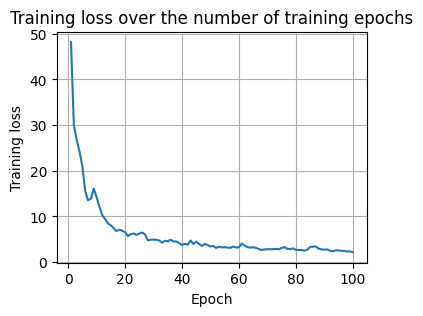

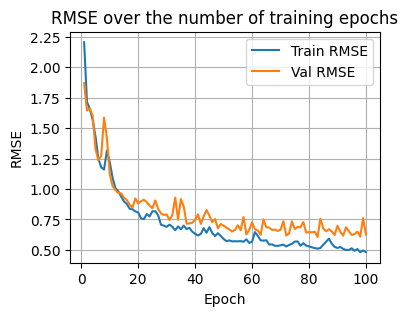

In [19]:
'''Plot training loss and training/validation errors for Solubility dataset'''
train_losses, train_rmses, val_rmses, run_time = train_results_sol
plot_train_loss(train_losses)
plot_train_val_error(train_rmses, val_rmses)

**Figure 4**: *Top*: Training loss over the number of training epochs for Solubility dataset. *Bottom*: Root mean square error of training and validation sets over the number of training epochs for Solubility dataset.

The Drug efficacy and Photovoltaic efficiency datasets are larger, so their trainings take about 15 minutes and 32 minutes, respectively. Thus, they have been trained locally (see commented codes) and the model states are saved.

In [20]:
'''Training drug efficacy dataset, training time 15 min'''
#model_eff = NeuralFingerprint(fp_length = 50, fp_depth = 4, fp_width = 50, pred_hidden_size = 100)
#train_results_eff = model_train(model_eff, eff_train_val_df, num_epoch = 50)
#train_losses, train_rmses, val_rmses, run_time = train_results_eff

'Training drug efficacy dataset, training time 15 min'

In [21]:
'''Training of photovotaic efficiency dataset, training time 32 min'''
#model_pce = NeuralFingerprint(fp_length = 50, fp_depth = 4, fp_width = 50, pred_hidden_size = 100)
#train_results_pce = model_train(model_pce, pce_train_val_df, num_epoch = 30)
#train_losses, train_rmses, val_rmses, run_time = train_results_pce

'Training of photovotaic efficiency dataset, training time 32 min'

The training losses and train/validation errors for both models have been recorded in a csv file, so I loaded the results to make plots as shown below. Overall, the training of photovotaic dataset went better than the drug efficacy data, likely because drug efficacy is a more complicated target that does not solely depend on the molecular structure.

In [22]:
'''Load saved results'''
saved_results = pd.read_csv("saved_models/saved_results.csv")

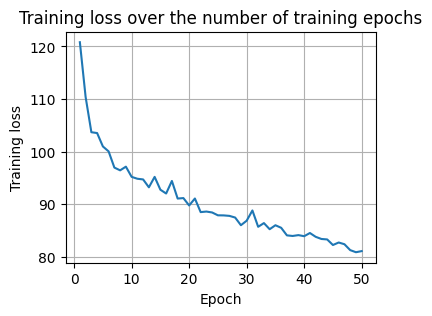

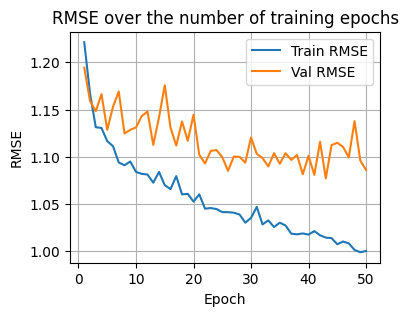

In [23]:
'''Plot results for drug efficacy dataset'''
plot_train_loss(saved_results["eff_training_loss"].dropna().tolist())
plot_train_val_error(saved_results["eff_training_err"].dropna().tolist(),
                     saved_results["eff_val_err"].dropna().tolist())

**Figure 5**: *Top*: Training loss over the number of training epochs for Drug efficacy dataset. *Bottom*: Root mean square error of training and validation sets over the number of training epochs for Drug efficacy dataset.

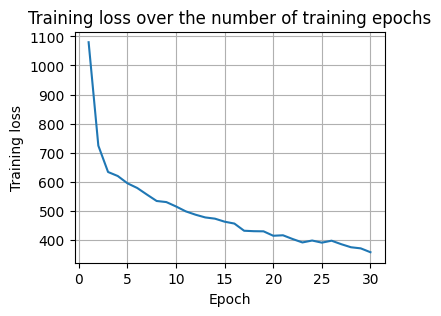

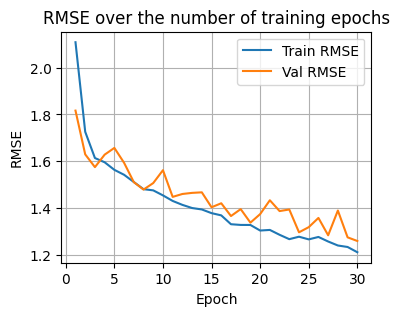

In [24]:
'''Plot results for Photovotaic efficacy dataset'''
plot_train_loss(saved_results["pce_training_loss"].dropna().tolist())
plot_train_val_error(saved_results["pce_training_err"].dropna().tolist(),
                     saved_results["pce_val_err"].dropna().tolist())

**Figure 6**: *Top*: Training loss over the number of training epochs for Photovotaic efficiency dataset. *Bottom*: Root mean square error of training and validation sets over the number of training epochs for Photovotaic efficiency dataset.

## Performance on Test Set

The trained model is applied on the test set to get the final model performance as root mean square error (RMSE) between true labels and predicted outcomes, which is the same as the original paper. The Solubility model is directly taken from the one trained above, while the other two models are loaded from local saves.

In [25]:
sol_test_rmse = model_test(sol_test_df, model_sol)

RMSE on the test set: 0.65


In [26]:
model_eff = NeuralFingerprint(fp_length = 50, fp_depth = 4, fp_width = 50, pred_hidden_size = 100)
model_eff.load_state_dict(torch.load("saved_models/trained_eff_model.pth"))
eff_test_rmse = model_test(eff_test_df, model_eff)

RMSE on the test set: 1.07


In [27]:
model_pce = NeuralFingerprint(fp_length = 50, fp_depth = 4, fp_width = 50, pred_hidden_size = 100)
model_pce.load_state_dict(torch.load("saved_models/trained_pce_model.pth"))
pce_test_rmse = model_test(pce_test_df, model_pce)

RMSE on the test set: 1.17


## Model Comparison

These test results, as well as the results reported in the original paper, are outlined in the table below.

| Dataset                   | Solubility      | Drug efficacy   | Photovotaic efficiency |
|--------------------------:|:----------------|:----------------|:-----------------------|
| Reported: Circular FP     | 1.40 $\pm$ 0.13 | 1.36 $\pm$ 0.10 | 2.00 $\pm$ 0.09        |
| Reported: Neural FP       | 0.52 $\pm$ 0.07 | 1.16 $\pm$ 0.03 | 1.43 $\pm$ 0.09        |
| **Replicated: Neural FP** | **0.65**        | **1.07**        | **1.17**               |

**Table 1**: Root mean square errors of replicated neural fingerprint model on three datasets compared with reported models in the original paper.

Overall, the results from the original paper can be replicated.

1. Replicated results on both the Drug efficacy and Photovotaic efficiency datasets slightly outperform the reported results. This is likely attributed to the improved training techniques over the recent years that have been built into the PyTorch package, such as model parameter initialization, optimization algorithms, and etc.

2. Replicated result on the Solubility dataset is slightly worse than the reported result, mainly because the dataset is so small (913 training samples) that the variability becomes high.

## Hypothesis Testing

**Hypothesis 1: Data-driven neural fingerprints achieve greater predictive performances than fixed circular fingerprints.**

Given that the reported results (in RMSE) using neural fingerprint models can be replicated, the Hypothesis 1 is thus validated: results using neural fingerprints models are consistently better than those obtained from fixed circular fingerprint models.

**Hypothesis 2: Circular fingerprints are a special case of neural fingerprints by having large random weights.**

According to the authors, the rationale is that by having large random weights, the tanh nonlinearity is now close to a step function (produces outcomes close to -1 or 1), and the softmax operator approaches a one-hot-coded argmax operator (inputs are highly differentiated), both of which are key ideas in the circular fingerprint model.

To test the second hypothesis, I used the `initialize_weights` method in the model class to reinitiate the parameters, so that they are uniformly sampled from a much wider range, i.e., [-3, 3]. Following the authors' approach, I scanned over 6 fingerprint depths (from 1 to 6) for both the regular model and the model with large intiial weights using the Solubility dataset. The code is shown below (commented), and the results have been obtained and saved.

In [28]:
#small_weights_rmses, large_weights_rmses = [], []

#for radius in range(1, 7):
'''Regular neural fingerprint model'''
    #model = NeuralFingerprint(fp_length = 50, fp_depth = radius, fp_width = 50, pred_hidden_size = 100)
    #train_results = model_train(model, sol_train_val_df, num_epoch = 100)
    #test_rmse = model_test(sol_test_df, model)
    #small_weights_rmses.append(test_rmse)
    
'''Neural fingerprint model with initial weights uniformly sampled from [-3, 3]'''
    #model = NeuralFingerprint(fp_length = 50, fp_depth = radius, fp_width = 50, pred_hidden_size = 100)
    #model.initialize_weights(3)
    #train_results = model_train(model, sol_train_val_df, num_epoch = 100)
    #test_rmse = model_test(sol_test_df, model)
    #large_weights_rmses.append(test_rmse)

'Neural fingerprint model with initial weights uniformly sampled from [-3, 3]'

In addition, the results from the circular fingerprint model are obtained using the original codes by the authors. The codes have been saved under the `circularfingerprint` folder. Running codes below are also commented.

In [29]:
'''Circular fingerprint model'''
#sys.path.append("circularfingerprint")
# from cf_main import run_ECFP_experiment

#sol_train_df, sol_val_df = train_test_split(sol_train_val_df, test_size = val_ratio, random_state = seed)
#ecfp_rmses = []
#for radius in range(1, 7):
    #test_err = run_ECFP_experiment(sol_train_df, sol_val_df, sol_test_df, radius)
    #ecfp_rmses.append(test_err)

'Circular fingerprint model'

Below, the saved results from all 3 models are plotted over the fingerprint depth.

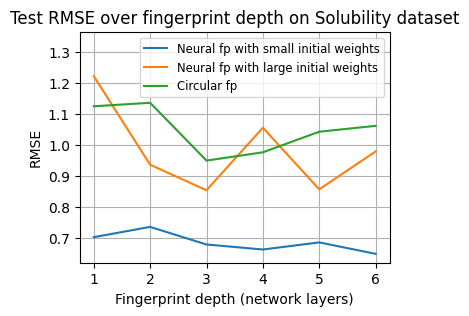

In [30]:
small_weights_rmses = saved_results["small_weights_rmse"].dropna().tolist()
large_weights_rmses = saved_results["large_weights_rmse"].dropna().tolist()
ecfp_rmses = saved_results["ecfp_rmse"].dropna().tolist()

plot_rmse_over_layers(small_weights_rmses, large_weights_rmses, ecfp_rmses,
                     "Neural fp with small initial weights",
                     "Neural fp with large initial weights")

**Figure 7**: Root mean square error on test sets over fingerprint depth on Solubility dataset, using 3 different models: neural fingerprint with small (regular) initial weights, neural fingerprint with large initial weights, and circular fingerprint.

This result shows that, within experimental error, neural fingerprint model with large initial weights overall perform similarly as the circular fingerprint model, while neural fingerprint model with small initial weights (regular model) performs better. This is consistent with the results from the original paper, and also validates Hypothesis 2.

## Ablation Study

**Ablation study: Assess whether real-valued fingerprint vectors are advantageous over binary vectors.**

The neural fingerprint model uses a softmax function to generate a real-valued vector instead of an indexing operation in circular fingerprints. While indexing is non-differentiable, I propose using a softmax with small temperature to mimic the indexing operation, generating nearly binary vectors. By setting `with_temp` argument to `True` in the model, a temperature = 0.01 will be applied to the softmax operation.

Similarly, I scanned over 6 fingerprint depths (from 1 to 6) for both the regular model and the model with small temperature using the Solubility dataset. The code is shown below (commented), and the results have been obtained and saved. Results of the circular fingerprint model are reused from the previous study.

In [31]:
#softmax_rmses, hardmax_rmses = [], []

#for radius in range(1, 7):
'''Regular neural fingerprint model'''
    #model = NeuralFingerprint(fp_length = 50, fp_depth = radius, fp_width = 50, pred_hidden_size = 100)
    #train_results = model_train(model, sol_train_val_df, num_epoch = 100)
    #test_rmse = model_test(sol_test_df, model)
    #softmax_rmses.append(test_rmse)

'''Neural fingerprint model using softmax with small temperature'''
    #model = NeuralFingerprint(fp_length = 50, fp_depth = radius, fp_width = 50, pred_hidden_size = 100,
    #                          with_temp = True)
    #train_results = model_train(model, sol_train_val_df, num_epoch = 100)
    #test_rmse = model_test(sol_test_df, model)
    #hardmax_rmses.append(test_rmse)

'Neural fingerprint model using softmax with small temperature'

Below, the saved results from all 3 models are plotted over the fingerprint depth.

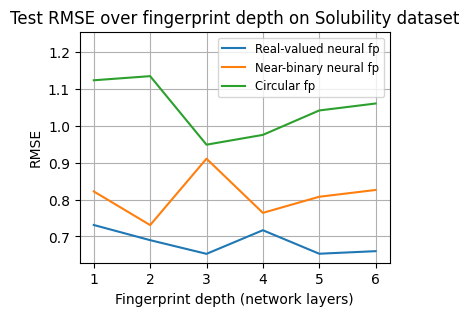

In [32]:
softmax_rmses = saved_results["softmax_rmse"].dropna().tolist()
hardmax_rmses = saved_results["hardmax_rmse"].dropna().tolist()

plot_rmse_over_layers(softmax_rmses, hardmax_rmses, ecfp_rmses,
                     "Real-valued neural fp",
                     "Near-binary neural fp")

**Figure 8**: Root mean square error on test sets over fingerprint depth on Solubility dataset, using 3 different models: real-valued neural fingerprint (regular), near-binary-valued neural fingerprint, and circular fingerprint.

This result shows that, neural fingerprint model using a near-indexing operation rather than a softmax (i.e., with near-binary fingerprints) is clearly better than the circular fingerprint model, but not as good as the regular neural fingerprint model (i.e., with real-valued fingerprints). Therefore, the answer to the ablation study is yes: having real-valued fingerprint vectors are indeed advantageous over binary vectors which lead to performance improvement.

This result is as expected because real-valued fingerprints can store richer information than multi-hot vectors, even when both are leanred from data. On the other hand, the fact that multi-hot neural fingerprints are still better than circular fingerprints supports the significance of data-driven feature learning.

# Discussion

Overall, this work is reproducible. The reproduced test set RMSE results on 3 datasets are all within 20% error range compared with reported values given all the model definition and training codes have been rewritten. The results of both hypothesis testings and ablation study are also consistent with the reported results, fully supporting the conclusion that the neural fingerprint model architecture (end-to-end learning of molecular structures) is able to better represent the molecular features than circular fingerprints, thus achieving better predictive performance.

During the reproduction studies, it is relatively easy to access all the data and put them together following the authors' thoughts. Furthermore, the understanding of the model architecture is straightforward, and the training time is manageable which makes it possible to perform hyperparameter refinement based on the new code implementations.

On the other hand, it is difficult to interpret all the codes written by the authors, not only because these codes were written in Python 2 with many different habits, but also due to the lack of comments and annotations which makes it hard to keep track of details. It is particularly challenging to find out what are the optimal hyperparameters that the authors used. Therefore, a significant part of the reproduction work relies on the reoptimization of these hyperparameters.

Therefore, one suggestion to the authors will be to add comments and annotations to the code to improve readability. Furthermore, it will be helpful to outline the optimal hyperparameters, or at least provide a range of values for hyperparameters so that reproducers can start from there.

# References

1. Duvenaud D. K., Maclaurin D., Iparraguirre J., Bombarell R., Hirzel T., Aspuru-Guzik A. and Adams R. P. (2015) Convolutional networks on graphs for learning molecular fingerprints. *Advances in Neural Information Processing Systems*, 2224-2232.

2. Rogers D. and Hahn M. (2010) Extended-connectivity fingerprints. *Journal of Chemical Information and Modeling*, 50(5): 742-754.

3. Delaney J. S. (2004) ESOL:Estimating aqueous solubility directly from molecular structure. *Journal of Chemical Information and Computer Sciences*, 44(3): 1000–1005.

4. Gamo F.-J., Sanz L. M., Vidal J., de Cozar C., Alvarez E., Lavandera J.-L., Vanderwall D. E., Green D. V. S., Kumar V., Hasan S., Brown J. R., Peishoff C. E., Cardon L. R. and Garcia-Bustos J. F. (2010) Thousands of chemical starting points for antimalarial lead identification. *Nature*, 465(7296): 305–310.

5. Hachmann J., Olivares-Amaya R., Atahan-Evrenk S., Amador-Bedolla C., Sánchez-Carrera R. S., Gold-Parker A., Vogt L., Brockway A. M. and Aspuru-Guzik A. (2011) *The Journal of Physical Chemistry Letters*, 2(17): 2241–2251.